GP Regression with GPflow
--

*James Hensman, 2015, 2016*

GP regression (with Gaussian noise) is the most straightforward GP model in GPflow. Because of the conjugacy of the latent process and the noise, the marginal likelihood $p(\mathbf y\,|\,\theta)$ can be computed exactly.

This notebook shows how to build a GPR model, estimate the parameters $\theta$ by both maximum likelihood and MCMC. 

In [1]:
import gpflow
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

First build a simple data set. 

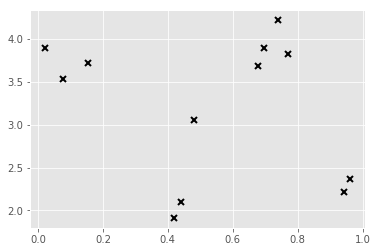

In [2]:
N = 12
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.plot(X, Y, 'kx', mew=2)

### Model construction

A GPflow model is created by instantiating one of the GPflow model classes, in this case GPR. we'll make a kernel `k` and instantiate a GPR object using the generated data and the kernel. We'll set the variance of the likelihood to a sensible initial guess, too. 

In [3]:
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
m = gpflow.models.GPR(X, Y, kern=k)
m.likelihood.variance = 0.01
m.compile()

### Prediction

GPflow models have several prediction methods:

 - `m.predict_f` returns the mean and variance of the latent function (f) at the points Xnew. 

 - `m.predict_f_full_cov` additionally returns the full covariance matrix of the prediction.

 - `m.predict_y` returns the mean and variance of a new data point (i.e. includes the noise varaince). In the case of non-Gaussian likelihoods, the variance is computed by (numerically) integrating the non-Gaussian likelihood. 

 - `m.predict_f_samples` returns samples of the latent function

 - `m.predict_density` returns the log-density of the points Ynew at Xnew. 
 
We'll use `predict_y` to make a simple plotting function. 

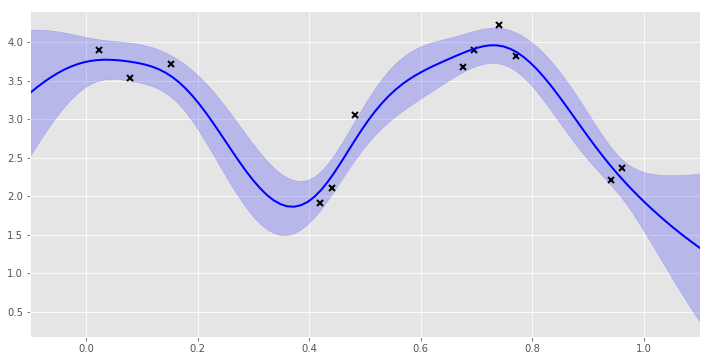

In [4]:
def plot(m):
    xx = np.linspace(-0.1, 1.1, 100)[:,None]
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(-0.1, 1.1)
plot(m)

### Using mean functions

All GPflow models can have parameterized mean functions, some simple ones are provided in `gpflow.mean_functions`. Here's a model with a Linear mean function. 

In [6]:
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
meanf = gpflow.mean_functions.Linear(1,0)
m = gpflow.models.GPR(X, Y, k, meanf)
m.likelihood.variance = 0.01
m.compile()

### Maximum Likelihood estimation of $\theta$

Getting the ML estimate of the parameters is a simple call to `optimize()`. By default, GPflow plugs into the L-BFGS-B algorithm via scipy. Here are the parameters before optimization: 

In [7]:
m

Here are the parameters after optimization, and a new plot. 

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 6.184465
  Number of iterations: 43
  Number of functions evaluations: 47


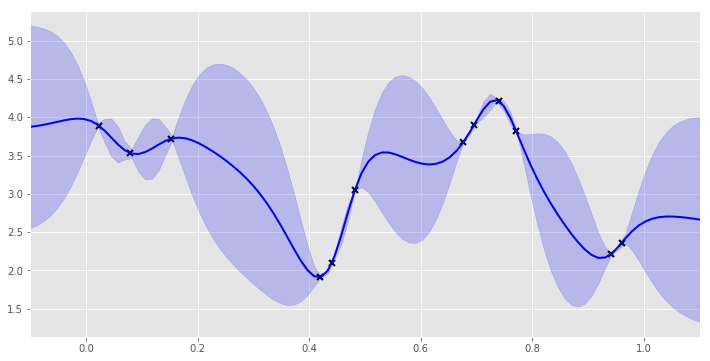

In [8]:
gpflow.train.ScipyOptimizer().minimize(m)
plot(m)
m

### MCMC for $\theta$

Here's a quick demonstration of how to obtain posteriors over the hyper-parameters in GP regression. First, we'll set some priors on the kernel parameters, then we'll run MCMC and see how much posterior uncertainty there is in the parameters.

First we'll choose rather arbitrary priors. 


In [16]:
m.clear()
m.kern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = gpflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = gpflow.priors.Gaussian(0., 10.)
m.compile()
m

ValueError: Shapes must be equal rank, but are 1 and 0
	From merging shape 1 with other shapes. for 'GPR_3/prior' (op: 'AddN') with input shapes: [], [1], [].

In [ ]:
samples = m.sample(500, epsilon=0.2, verbose=1)

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(samples)

The samples are in the same form as the sampler runs (i.e. in the unconstrained space, with and fixed parameters removed). Each row is one sample, and each column is one free variable. GPflow can convert the samples into a nice DataFrame, which is much more interpretable. 

In [ ]:
sample_df = m.get_samples_df(samples)
sample_df.head()

In [ ]:
# make a more informative plot
plt.figure(figsize=(16, 4))
for lab, s in sample_df.iteritems():
    plt.plot(s, label=lab)
_ = plt.legend(loc=0)

In [ ]:
f, axs = plt.subplots(1,3, figsize=(12,4))

axs[0].plot(sample_df['model.likelihood.variance'],
            sample_df['model.kern.variance'], 'k.', alpha = 0.15)
axs[0].set_xlabel('noise_variance')
axs[0].set_ylabel('signal_variance')

axs[1].plot(sample_df['model.likelihood.variance'],
            sample_df['model.kern.lengthscales'], 'k.', alpha = 0.15)
axs[1].set_xlabel('noise_variance')
axs[1].set_ylabel('lengthscale')

axs[2].plot(sample_df['model.kern.lengthscales'],
            sample_df['model.kern.variance'], 'k.', alpha = 0.1)
axs[2].set_xlabel('lengthscale')
axs[2].set_ylabel('signal_variance')

To plot the posterior of predictions, we'll iterate through the samples and set the model state with each samnple. then, for tht state (set of hyper-parameters) we'll draw some samples from the prediction function. 

In [ ]:
#plot the function posterior
xx = np.linspace(-0.1, 1.1, 100)[:,None]
plt.figure(figsize=(12, 6))
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    f = m.predict_f_samples(xx, 1)
    plt.plot(xx, f[0,:,:], 'b', lw=2, alpha = 0.05)
    
plt.plot(X, Y, 'kx', mew=2)
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(0, 6)